# Querying database with JSONB field

This notebook shows examples of datasets that have key information in their JSONB field, and how to query and retrieve data and images from them.
In this case, the JSONB field contains information about which protein was imaged. Many of these datasets also have child datasets which contain data files related to the images, so we'll also select a dataset and plot it along with its child.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import sys
import time

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import imaging_db.filestorage.s3_storage as s3_storage
import imaging_db.filestorage.local_storage as local_storage

/Users/jenny.folkesson/Code/imagingDB


In [2]:
import imaging_db.database.db_operations as db_ops
import imaging_db.utils.db_utils as db_utils

importlib.reload(db_ops)
credentials_filename = "/Users/jenny.folkesson/Code/db_credentials.json"
credentials_str = db_utils.get_connection_str(credentials_filename)

Now we will find all datasets containing protein TOPOR. As you will see, there are several datasets containing images of the same protein.

In [3]:
with db_ops.session_scope(credentials_str) as session:
    datasets = session.query(db_ops.DataSet) \
        .join(db_ops.FramesGlobal) \
        .join(db_ops.Frames) \
        .filter(db_ops.FramesGlobal.metadata_json.contains({"protein_name": "TOPOR"})) \
        .all()
    
    print("Nbr of datasets imaging the TOPOR protein:", len(datasets))
    for d in datasets:
        print(d.dataset_serial)

Nbr of datasets imaging the TOPOR protein: 6
ML-2018-11-08-15-06-10-0001
ML-2018-11-08-15-06-18-0001
ML-2018-11-08-15-36-16-0001
ML-2018-11-08-15-36-44-0001
ML-2018-11-08-15-37-09-0001
ML-2018-11-08-15-37-34-0001


Find all unique protein names in database and order them alphabetically.

In [4]:
with db_ops.session_scope(credentials_str) as session:
    proteins = session.query(
        db_ops.FramesGlobal.metadata_json['protein_name']) \
            .distinct() \
            .order_by(db_ops.FramesGlobal.metadata_json['protein_name'])

    for p in proteins:
        print(p[0])

AAMP
AATF
ABCE1
ABL1
ABR
ACAP2
ACAP3
ACLY
ACTB
ACTG1
ACTN1
ACTN2
ACTR2
ACTR3
ADCK2
AGAP1
AGAP3
AGO1
AGO2
AGPAT2
AGPAT3
AGPAT4
AGPAT5
AGPAT6
AGPAT9
AGTRAP
AHCY
AHSA1
AKAP12
AKAP13
AKAP8L
AKR1A1
AKT1
AKT1S1
AKT2
AKT3
ALCAM
ALDH16A1
ALDH18A1
ALDH7A1
ALDH9A1
ALG2
ALS2
ALX1
ANAPC1
ANAPC10
ANAPC11
ANAPC13
ANAPC15
ANAPC16
ANAPC2
ANAPC4
ANAPC5
ANAPC7
ANKRD10
ANKRD13A
ANKRD13B
ANKRD13C
ANKRD17
ANKRD27
ANKRD28
ANKRD30BL
ANKRD39
ANKRD40
ANKRD46
ANKRD52
ANKRD54
ANKRD9
ANKS3
ANKS6
ANKZF1
ANLN
ANXA11
AP2M1
AP2S1
APC
APPL1
APPL2
ARAF
ARAP1
ARCN1
ARF1
ARF3
ARF4
ARF5
ARF6
ARFGAP1
ARFGAP2
ARFGAP3
ARFGEF1
ARFGEF2
ARFIP1
ARFIP2
ARHGAP1
ARHGAP11A-B
ARHGAP17
ARHGAP19
ARHGAP21
ARHGAP22
ARHGAP35
ARHGAP5
ARHGAP8
ARHGEF1
ARHGEF12
ARHGEF18
ARHGEF25
ARHGEF26
ARHGEF39
ARHGEF7
ARID1A
ARID1B
ARL1
ARL10
ARL13B
ARL14EP
ARL15
ARL16
ARL17A
ARL17B
ARL2
ARL2BP
ARL3
ARL4A
ARL4D
ARL5A
ARL5B
ARL6
ARL6IP1
ARL6IP4
ARL6IP5
ARL6IP6
ARL8A
ARL8B
ARMCX3
ARPC2
ARPC3
ASAP1
ASIC1
ASS1
ATG9A
ATL2
ATL3
ATM
ATP1A1
ATP2A2
ATP2B1
ATP6AP1
A

Get first channel for a given dataset ID and print its global metadata.

In [3]:
dataset_id = 'ML-2018-11-08-15-06-10-0001'
db_inst = db_ops.DatabaseOperations(
    dataset_serial=dataset_id,
)
with db_ops.session_scope(credentials_str) as session:
    global_meta, frames_meta = db_inst.get_frames_meta(
        session=session,
        channels=0,
    )
    print(global_meta)

{'storage_dir': 'raw_frames/ML-2018-11-08-15-06-10-0001', 'nbr_frames': 70, 'im_width': 1024, 'im_height': 1024, 'nbr_slices': 35, 'nbr_channels': 2, 'im_colors': 1, 'nbr_timepoints': 1, 'nbr_positions': 1, 'bit_depth': 'uint16', 'metadata_json': {'plate_id': 'E1', 'stack_nbr': 3, 'file_origin': '/Volumes/MicroscopyData/ML_group/Plate_Microscopy/mNG96wp6/PublicationQuality_IJClean/E1_3_TOPOR_Jin_C6_PyProcessed_IJClean.tif', 'protein_name': 'TOPOR'}}


Now we have the metadata we're interested in, we can retrieve the corresponding images.

In [4]:
data_loader = local_storage.LocalStorage(storage_dir=global_meta["storage_dir"])
t0 = time.time()
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print("Time to load stack: {:.2f}".format(time.time() - t0))
print("Stack shape:", im_stack.shape)
print("Dimensions and order:", dim_order)

Time to load stack: 0.73
Stack shape: (1024, 1024, 35)
Dimensions and order: XYZ


In [9]:
# Plot frames as gif
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 12]
plt.axis('off')

frames = []
for idx in range(im_stack.shape[-1]):
    im = plt.imshow(im_stack[..., idx], animated=True)
    frames.append([im])

anim_kmean = animation.ArtistAnimation(fig, frames)
plt.close(anim_kmean._fig)

# Call function to display the animation
HTML(anim_kmean.to_html5_video())

Instead of selecting a given dataset ID, maybe we're more interested in visualizing a certain protein. Since many of these datasets also have children datasets containing related files, we will find the child dataset as well. In this case the child is a mass spectrometry plot.

In [5]:
with db_ops.session_scope(credentials_str) as session:
    datasets = session.query(db_ops.DataSet) \
        .join(db_ops.FramesGlobal) \
        .join(db_ops.Frames) \
        .filter(db_ops.FramesGlobal.metadata_json.contains({"protein_name": "CCT7"})) \
        .all()
    print("Nbr datasets of CCT7 protein:", len(datasets))

Nbr datasets of CCT7 protein: 6


Since there are many, let's just look at the first one.

In [6]:
with db_ops.session_scope(credentials_str) as session:
    parent_dataset = session.query(db_ops.DataSet) \
        .join(db_ops.FramesGlobal) \
        .join(db_ops.Frames) \
        .filter(db_ops.FramesGlobal.metadata_json.contains({"protein_name": "CCT7"})) \
        .first()
    
    # Get metadata so we can load images
    db_inst = db_ops.DatabaseOperations(
        dataset_serial=parent_dataset.dataset_serial,
    )
    global_meta, frames_meta = db_inst.get_frames_meta(
        session=session,
    )
    
    # Find child dataset
    child_dataset = session.query(db_ops.DataSet) \
        .filter(db_ops.DataSet.parent_id == parent_dataset.id).one()
    # Get child dataset file path
    child_dir = child_dataset.file_global.storage_dir
    child_file_name = child_dataset.file_global.file_name
    print("child dataset path: {}/{}".format(child_dir, child_file_name))

child dataset path: raw_files/ML-2018-11-14-13-33-33-0002/C12_CCT7_A_FACS.png


Load parent and child datasets.
Since the child dataset file is an image, we can load it from storage using local or S3 storage classes.

In [7]:
data_loader = local_storage.LocalStorage(storage_dir=global_meta["storage_dir"])
t0 = time.time()
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print("Time to load stack: {:.2f}".format(time.time() - t0))
print("Stack shape:", im_stack.shape)
print("Dimensions and order:", dim_order)

data_loader = local_storage.LocalStorage(storage_dir=child_dir)
im_child = data_loader.get_im(child_file_name)
print("Child im shape:", im_child.shape)

Time to load stack: 1.66
Stack shape: (1024, 1024, 35, 2)
Dimensions and order: XYZC
Child im shape: (480, 640, 3)


Plot center slices of the two channels, then the mass spec image.

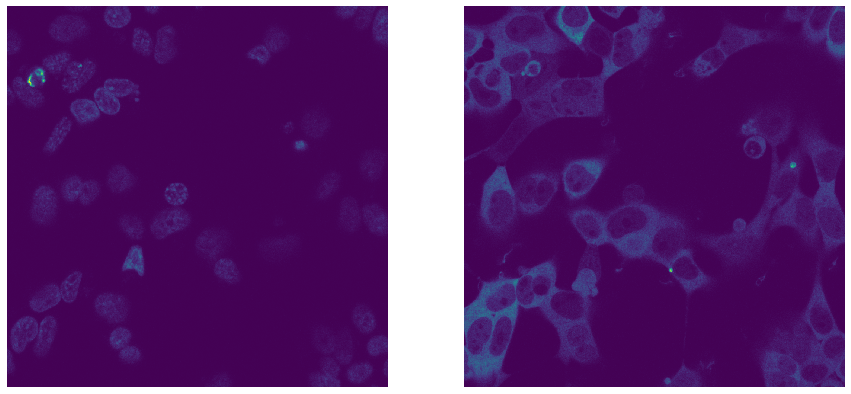

In [9]:
plt.subplot(121); plt.imshow(im_stack[:, :, 17, 0])
plt.axis('off')
plt.subplot(122); plt.imshow(im_stack[:, :, 17, 1])
plt.rcParams['figure.figsize'] = [15, 20]
plt.axis('off')
plt.show()

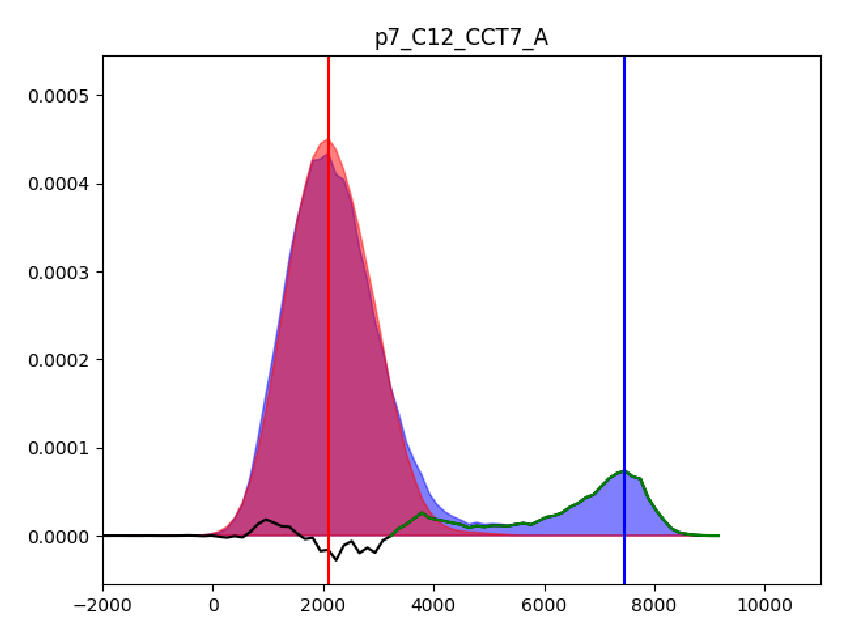

In [10]:
plt.imshow(im_child)
plt.axis('off')
plt.show()